<a href="https://colab.research.google.com/github/sepehrilami/DataScienceInternship-AIMed/blob/master/PLS/PLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Importing!

import torch
import torch.nn as nn
from torch.autograd import Variable

import argparse
import os
import random
import torch.optim as optim

import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from skimage.transform import resize
from time import time

# %matplotlib inline
# from __future__ import print_function
# from IPython.display import HTML
# import torch.nn.parallel
# import torch.backends.cudnn as cudnn
# import nibabel as nib
# import torch.utils.data
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torchvision.utils as vutils

In [2]:
#Requird for reading mhd format
!pip install SimpleITK
import SimpleITK as sitk

In [3]:
#Reading 3 samples from VESSEL12 dataset
!wget https://www.dropbox.com/sh/1j2x17k8y18k3l6/AACkAc6bCEqYVXBdODFo6Iqya/VESSEL12_ExampleScans.tar.bz2

--2020-11-02 06:58:49--  https://www.dropbox.com/sh/1j2x17k8y18k3l6/AACkAc6bCEqYVXBdODFo6Iqya/VESSEL12_ExampleScans.tar.bz2
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/1j2x17k8y18k3l6/AACkAc6bCEqYVXBdODFo6Iqya/VESSEL12_ExampleScans.tar.bz2 [following]
--2020-11-02 06:58:49--  https://www.dropbox.com/sh/raw/1j2x17k8y18k3l6/AACkAc6bCEqYVXBdODFo6Iqya/VESSEL12_ExampleScans.tar.bz2
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca2be0d20cedf41948ec380bcad.dl.dropboxusercontent.com/cd/0/inline/BCZlfq0L51fE40x4RIMJpuA0PaZaIIQ8Ykuq1vtwoenO6oDftBRQwj_Bjgp0ubQLtukIpQifSnBhcMkjPNlOKiF9BuSD0Bad3IxeUILhi3HhGw/file# [following]
--2020-11-02 06:58:50--  https://uca2be0d20cedf41948ec380bcad.dl.dropboxusercontent.com/cd/0/inline/

In [4]:
#Unzip samples
!tar xf VESSEL12_ExampleScans.tar.bz2

In [3]:
def read_mhd(file):
    return sitk.GetArrayFromImage(sitk.ReadImage(file, sitk.sitkFloat32))

In [4]:
vessel12_21 = read_mhd("Scans/VESSEL12_21.mhd")
vessel12_21_mask = read_mhd("Lungmasks/VESSEL12_21.mhd")
vessel12_22 = read_mhd("Scans/VESSEL12_22.mhd")
vessel12_22_mask = read_mhd("Lungmasks/VESSEL12_22.mhd")
vessel12_23 = read_mhd("Scans/VESSEL12_23.mhd")
vessel12_23_mask = read_mhd("Lungmasks/VESSEL12_23.mhd")

In [28]:
vessel12_23_mask.shape

(418, 512, 512)

In [29]:
def draw(images, columns=4):
    rows = int(np.ceil(images.shape[0] / columns))
    max_size = 20
    
    width = max(columns * 5, max_size)
    height = width * rows // columns

    plt.figure(figsize=(width, height))
    plt.gray()
    plt.subplots_adjust(0,0,1,1,0.01,0.01)
    for i in range(images.shape[0]):
        plt.subplot(rows,columns,i+1), plt.imshow(images[i]), plt.axis('off')
        # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
    plt.show()

def draw_masked(images, masks, columns=4):
    assert images.shape == masks.shape
    
    rows = int(np.ceil(images.shape[0] / columns))
    max_size = 20
    
    width = min(columns * 5, max_size)
    height = width * rows // columns

    fig = plt.figure(figsize=(width, height))
    plt.gray()
    plt.subplots_adjust(0,0,1,1,0.01,0.01)
    
    X, Y = np.meshgrid(np.arange(masks.shape[1]), np.arange(masks.shape[2]))
    
    for i in range(images.shape[0]):
        ax = fig.add_subplot(rows,columns,i+1)
        if masks[i].sum() > 0:
            ax.contour(X, Y, masks[i], 1, colors='red', linewidths=0.5)
        ax.imshow(images[i], origin='lower', cmap='gray')
        plt.axis('off')
    
    plt.show()

In [30]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.01)
        nn.init.constant_(m.bias.data, 0)

In [31]:
class DSconv(nn.Module):
  def __init__(self, in_channels, out_channels, DSkernel, depth_stride, DSstride, DSpadding, dilation=1):
    super(DSconv, self).__init__()

    self.dsconv = nn.Sequential(
        #Input is 10, 512, 512

        nn.Conv3d(in_channels, in_channels, DSkernel, depth_stride, DSpadding, dilation, groups = in_channels),

        nn.BatchNorm3d(in_channels),
        nn.ReLU(inplace=True),
        nn.Conv3d(in_channels, out_channels, 1 ,DSstride, 0, dilation),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, input):
    # print("dsconv shape of input:", input.shape)  
    return self.dsconv(input)


class DRDB(nn.Module):
      def __init__(self, in_channels, DRDBpadding):
        super(DRDB, self).__init__()
        
        DSkernel = 3
        DSstride = 1
        DSpadding = DRDBpadding
        self.conv_1 = DSconv(in_channels, in_channels, 3, 1, DSstride, 1, 1)
        self.conv_2 = DSconv(in_channels * 2 , in_channels * 2, 3, 1, DSstride, 2, 2)
        self.conv_3 = DSconv(in_channels * 4, in_channels * 4, 3, 1, DSstride, 3, 3)
        self.conv_4 = DSconv(in_channels * 8, in_channels * 8, 3, 1, DSstride, 4, 4)
        
        self.final_conv = nn.Conv3d(in_channels * 16, in_channels, 1, DSstride, 0,bias=False)

      def forward(self, DRDBinput):
        first_convolved = self.conv_1(DRDBinput)
        concat = torch.cat([first_convolved, DRDBinput], dim=1)
        second_convolved = self.conv_2(concat)
        concat = torch.cat([second_convolved, concat], dim=1)
        third_convolved = self.conv_3(concat)
        concat = torch.cat([third_convolved, concat], dim=1)
        forth_convolved = self.conv_4(concat)
        concat = torch.cat([forth_convolved, concat], dim=1)
        xg0 = self.final_conv(concat)
        return xg0 + DRDBinput

In [32]:
#Testing DRDB

# test = torch.zeros(size= [1, 17, 10, 512, 512], device = 'cuda:0', dtype = torch.float16)
# drdb = DRDB(17, 0)
# drdb = drdb.to('cuda:0').half()
# out = drdb(test)
# out.shape

In [33]:
#Testing DSconv

# test = torch.zeros(size= [1, 1, 8, 512, 512], device = 'cuda:0', dtype = torch.float16)
# dsconv = nn.Sequential( DSconv(1, 16, 3, 2, 1, 1, dilation = 1),
# DSconv(16, 16, 3, 2, 1, 1, dilation = 1),
# DSconv(16, 1, 3, 2, 1, 1, dilation = 1))
# dsconv = dsconv.to('cuda:0').half()
# out = dsconv(test)
# out.shape

In [34]:
torch.cuda.empty_cache()
import gc
gc.collect()

1151

In [35]:
class PLSnet(nn.Module):
  def __init__(self, DSkernel, DSstride, DSpadding, C):
    super(PLSnet, self).__init__()

    self.dsconvolve_1 = DSconv(1, 16, DSkernel, 2, DSstride, DSpadding)
    self.dsconvolve_2 = DSconv(17, 64, DSkernel, 2, DSstride, DSpadding)
    self.dsconvolve_3 = DSconv(65, 128, DSkernel, 2, DSstride, DSpadding)

    self.mid_dsconvolve_1 = DSconv(17, 2*C, DSkernel, 1, DSstride, DSpadding, 1)
    self.mid_dsconvolve_2 = DSconv(65, 2*C, DSkernel, 1, DSstride, DSpadding, 1)
    
    self.decoder_dsconvolve_1 = DSconv(129, 2*C, DSkernel, 1, DSstride, DSpadding, 1)
    self.decoder_dsconvolve_2 = DSconv(4*C, 2*C, DSkernel, 1, DSstride, DSpadding, 1)
    self.decoder_dsconvolve_3 = DSconv(4*C, 2*C, DSkernel, 1, DSstride, DSpadding, 1)

    self.oneconv = nn.Conv3d(2*C, 1, 1, DSstride, 0)

    DRDBpadding = DSpadding
    self.drdb = DRDB(17, DRDBpadding)
    self.drdbx2 = DRDB(65, DRDBpadding)
    self.drdbx4 = DRDB(129, DRDBpadding)

    self.TLupsample = nn.Upsample(scale_factor = 2, mode='trilinear')
    self.sigmoid = nn.Sigmoid()

  def forward(self, InputImage, real_mask):

    # resolution = 1 in encoder
    DSconv_output = self.dsconvolve_1(InputImage)
    # print("dsconv: ", DSconv_1.shape)
    InputImage = nn.functional.interpolate(InputImage, scale_factor = 0.5, mode='trilinear')
    # print("image: ", InputImage.shape)
    concat_output = torch.cat([DSconv_output,InputImage], dim=1)
    DRDB1_output = self.drdb(concat_output)
    # resolution = 2 in encoder
    DSconv_output = self.dsconvolve_2(DRDB1_output)
    InputImage = nn.functional.interpolate(InputImage, scale_factor = 0.5, mode='trilinear')
    concat_output = torch.cat([DSconv_output,InputImage], dim = 1)
    DRDB2_output = self.drdbx2(self.drdbx2(concat_output))
    # resolution = 3 in encoder
    DSconv_output = self.dsconvolve_3(DRDB2_output)

    InputImage = nn.functional.interpolate(InputImage, scale_factor = 0.5, mode = 'trilinear')
    concat_output = torch.cat([DSconv_output,InputImage], dim = 1)

    DSconv_output = self.decoder_dsconvolve_1(self.drdbx4(self.drdbx4(self.drdbx4(self.drdbx4(concat_output)))))
    upsample_output = self.TLupsample(DSconv_output) 
    # resolution = 2 in decoder
    DSconv_output = self.mid_dsconvolve_2(DRDB2_output)
    concat_output = torch.cat([upsample_output, DSconv_output], dim = 1)
    DSconv_output = self.decoder_dsconvolve_2(concat_output)
    upsample_output = self.TLupsample(DSconv_output)
    # resolution = 1 in decoder
    DSconv_output = self.mid_dsconvolve_1(DRDB1_output)
    concat_output = torch.cat([upsample_output, DSconv_output], dim = 1)
    DSconv_output = self.decoder_dsconvolve_2(concat_output)
    upsample_output = self.TLupsample(DSconv_output)
    # resolution = 0 in decoder

    output = self.oneconv(upsample_output)

    predicted = self.sigmoid(output)

    loss_output = F.binary_cross_entropy(predicted, real_mask.squeeze(dim = 1))    

    return predicted, loss_output

In [36]:
# in_channels = 10
# out_channels = 256
DSkernel = 3
DSstride = 1
DSpadding = 1

C = 6   #number of classes

model = PLSnet(DSkernel, DSstride, DSpadding, C)
model = model.cuda()

In [37]:
optimizer = torch.optim.Adam(filter(
    lambda p : p.requires_grad, model.parameters()),
    lr = 0.001
)

In [38]:
# output = torch.randn(1, 2, 8, 512, 512, dtype=torch.float32)
# print(output.shape)
# target = torch.empty(1, 8, 512, 512, dtype=torch.float32).random_(2)
# print(target.shape)
# print(F.cross_entropy(output, target))

In [41]:
x_train = vessel12_21[200:208]
y_train = vessel12_21_mask[200:208]
x_val = vessel12_21[208:216]
y_val = vessel12_21_mask[208:216]

batch_size = 1
batch_x_placeholder = torch.zeros(size= [batch_size, 1, x_train.shape[0], 512, 512], dtype = torch.float32, device = 'cuda:0')
batch_y_placeholder = torch.zeros(size= [batch_size, 1, y_train.shape[0], 512, 512], dtype = torch.float32, device = 'cuda:0')

epochs = 30

train_loss = np.zeros((batch_size * epochs,))
val_loss = np.zeros((batch_size * epochs,))
train_acc = np.zeros((batch_size * epochs,))
val_acc = np.zeros((batch_size * epochs,))


In [42]:
iters_per_epoch = int(np.ceil(1.0 * len(x_train) / batch_size))

for e in range(epochs):
    t_start = time()

    model.train() # training phase

    # shuffling
    inds = np.arange(len(x_train))
    np.random.shuffle(inds)

    epoch_loss = 0
    true_positive = 0


    # iterating over the whole training set
    for iter in range(iters_per_epoch):

        batch_inds = inds[iter * batch_size: min(len(inds), (iter + 1) * batch_size)]
        # print(batch_inds)

        # reshaping placeholders
        if len(batch_inds) != len(batch_x_placeholder):
            batch_x_placeholder.resize_([len(batch_inds), 1, x_train.shape[0], 512, 512])
            batch_y_placeholder.resize_([len(batch_inds), 1, x_train.shape[0], 512, 512])


        batch_x_placeholder.copy_(torch.Tensor(x_train[batch_inds, np.newaxis, np.newaxis, :, :]))

        batch_y_placeholder.copy_(torch.Tensor(y_train[batch_inds, np.newaxis, np.newaxis, :, :]))

        
        b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
        b_decision = b_decision.detach().cpu().numpy()
      
        epoch_loss += float(b_loss) / iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
        true_positive += np.sum(y_train[batch_inds[0]].astype(int) == b_decision)
        
        b_loss.backward() # calculates derivations

        optimizer.step()
        optimizer.zero_grad() # CARE: MUST DO

    epoch_train_accuracy = true_positive * 100.0 / len(x_train)
    train_loss[e] = epoch_loss
    train_acc[e] = epoch_train_accuracy
    
 # Validating over validation data
    with torch.no_grad():
        model.eval()  # validation phase

        val_inds = np.arange(len(x_val))

        val_iters_per_epoch = int(np.ceil(1.0 * len(x_val) / batch_size))

        epoch_validation_loss = 0
        val_true_positive = 0


        # iterating over the whole training set
        for iter in range(val_iters_per_epoch):

            val_batch_inds = val_inds[iter * batch_size: min(len(val_inds), (iter + 1) * batch_size)]

            # reshaping placeholders
            if len(batch_inds) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(batch_inds), 1, x_val.shape[0], 512, 512])
                batch_y_placeholder.resize_([len(batch_inds), 1, x_val.shape[0], 512, 512])

            batch_x_placeholder.copy_(torch.Tensor(x_train[batch_inds, np.newaxis, np.newaxis, :, :]))

            batch_y_placeholder.copy_(torch.Tensor(y_train[batch_inds, np.newaxis, np.newaxis, :, :]))

            b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
            b_decision = b_decision.cpu().numpy()
        
            epoch_validation_loss += float(b_loss) / val_iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
            val_true_positive += np.sum(y_val[val_batch_inds].astype(int) == b_decision)
                
        epoch_validation_accuracy = val_true_positive * 100.0 / len(x_val)
        val_loss[e] = epoch_validation_loss
        val_acc[e] = epoch_validation_accuracy
        # TO Complete
    
    print(f'Train epoch Loss: {epoch_loss:.4f}, Validation Loss: {epoch_validation_loss:.4f}')

    # Saving the model and optimizer state
    torch.save({
            'epoch': e,
            'optimizer_state_dict': optimizer.state_dict(),
            'model_state_dict': model.state_dict(),
            'train_loss': epoch_loss,
            'train_accuracy': epoch_train_accuracy,
            # 'validation_loss': epoch_validation_loss,
            # 'validation_accuracy': epoch_validation_accuracy
        }, 'epoch_%d_state.pt' % e)
    
    

    print('Epoch %d ended in %.2f secs.' % (e, time() - t_start,))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Using a target size (torch.Size([1, 8, 512, 51

Train epoch Loss: 0.3843, Validation Loss: 0.5543
Epoch 0 ended in 154.26 secs.
Train epoch Loss: 0.3188, Validation Loss: 0.4864
Epoch 1 ended in 154.25 secs.
Train epoch Loss: 0.2830, Validation Loss: 0.4310
Epoch 2 ended in 154.19 secs.
Train epoch Loss: 0.2576, Validation Loss: 0.4125
Epoch 3 ended in 154.17 secs.
Train epoch Loss: 0.2373, Validation Loss: 0.3847
Epoch 4 ended in 154.19 secs.
Train epoch Loss: 0.2201, Validation Loss: 0.3487
Epoch 5 ended in 154.22 secs.
Train epoch Loss: 0.2048, Validation Loss: 0.3339
Epoch 6 ended in 154.20 secs.
Train epoch Loss: 0.1909, Validation Loss: 0.3181
Epoch 7 ended in 154.17 secs.
Train epoch Loss: 0.1782, Validation Loss: 0.3116
Epoch 8 ended in 154.20 secs.
Train epoch Loss: 0.1664, Validation Loss: 0.2990
Epoch 9 ended in 154.20 secs.
Train epoch Loss: 0.1556, Validation Loss: 0.2902
Epoch 10 ended in 154.21 secs.
Train epoch Loss: 0.1455, Validation Loss: 0.2842
Epoch 11 ended in 154.17 secs.
Train epoch Loss: 0.1362, Validation L

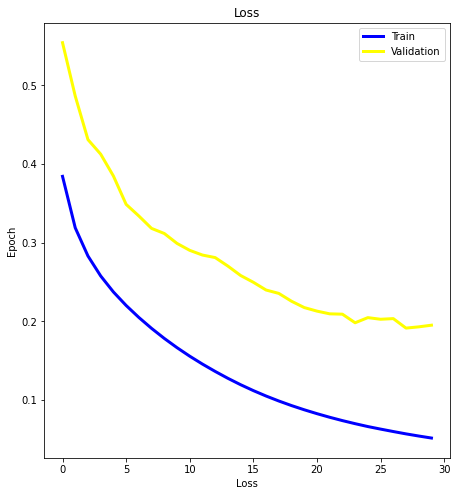

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))


# loss
ax = fig.add_subplot(121)
ax.set_title('Loss')
ax.set_xlabel('Loss')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='blue', linewidth=3)
plt.plot(val_loss, label='Validation', color='yellow', linewidth=3)

plt.legend()

In [45]:
x_test = vessel12_23[216:224]
y_test = vessel12_23_mask[216:224]

In [46]:
with torch.no_grad():
        model.eval()  # validation phase

        val_inds = np.arange(len(x_test))

        val_iters_per_epoch = int(np.ceil(1.0 * len(x_test) / batch_size))

        epoch_validation_loss = 0
        val_true_positive = 0
        predictions = []

        # iterating over the whole training set
        for iter in range(val_iters_per_epoch):

            val_batch_inds = val_inds[iter * batch_size: min(len(val_inds), (iter + 1) * batch_size)]

            # reshaping placeholders
            if len(batch_inds) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(batch_inds), 1, x_test.shape[0], 512, 512])
                batch_y_placeholder.resize_([len(batch_inds), 1, x_test.shape[0], 512, 512])

            batch_x_placeholder.copy_(torch.Tensor(x_test[batch_inds, np.newaxis, np.newaxis, :, :]))

            batch_y_placeholder.copy_(torch.Tensor(y_test[batch_inds, np.newaxis, np.newaxis, :, :]))

            b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
            b_decision = b_decision.cpu().numpy()

            predictions.append(b_decision)
        
            epoch_validation_loss += float(b_loss) / val_iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
            val_true_positive += np.sum(y_test[val_batch_inds].astype(int) == b_decision)
                
        epoch_validation_accuracy = val_true_positive * 100.0 / len(x_test)
        val_loss = epoch_validation_loss
        val_acc = epoch_validation_accuracy


print('Test Loss %.4f' % val_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Using a target size (torch.Size([1, 8, 512, 51

Test Loss 0.2675


In [25]:
y_test = y_test.astype(int)
predictions = np.concatenate(predictions)

In [26]:
x_test.shape

(8, 512, 512)

In [27]:
right_images = x_test[predictions == y_test]
print('there are %d correct predictions. We have chosen a few of them randomly.' % len(right_images))
right_labels = predictions[predictions == y_test]
right_indices = np.random.choice(np.arange(len(right_images)), size=80)

images = right_images[right_indices]
label_predictions = right_labels[right_indices]
texts = [f'{label_predictions[i]}' for i in range(len(right_indices))]
columns = 16
rows = 5

fig = plt.figure(figsize=(1.2 * columns, 1.2 * rows))

for i in range(columns * rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title(texts[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(images[i].reshape((28, 28)))

there are 0 correct predictions. We have chosen a few of them randomly.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: ignored

In [ ]:
torch.cuda.reset_max_memory_allocated